In [2]:

import collections

import matplotlib.pyplot as plt
import pandas as pd
import sklearn.tree as tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import train_test_split

seed = 42

In [3]:
#First save the preprocessed data to .csv. Therefore, we can reload it without going through preprocessing again.

#datanona.to_csv('./save_df.csv')
data_nona = pd.read_csv('./save_df_net.csv')
seed = 42
data_nona

,ID,deceased,w1SMOKECIG,w1ALCOHOL,w1GENDER,w1CONDITNS_3,w1married,w1raceblk,w1PHYSACT,w1EDUC,...,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean,net_count,num_unique,prop_live,avg_talk,avg_close
0,100005,0.0,0.0,1.0,2.0,0.0,1,0,3.0,4.0,...,30.248745,5.500000,11.74600,6.0,17.770000,5,4,0.20,0.60,2.80
1,100033,0.0,0.0,1.0,2.0,0.0,0,0,4.0,3.0,...,44.103840,6.600000,2.92200,5.0,34.279999,5,3,0.20,0.40,2.60
2,100080,0.0,0.0,0.0,1.0,0.0,1,0,3.0,3.0,...,37.678516,7.300000,0.55200,5.0,21.135000,5,3,0.20,0.20,2.80
3,100154,0.0,0.0,1.0,2.0,0.0,1,0,0.0,2.0,...,25.401367,5.700000,0.49900,5.0,28.535000,5,4,0.20,0.40,2.80
4,100203,0.0,0.0,0.0,2.0,0.0,0,0,0.0,1.0,...,27.895041,6.097641,3.19458,7.0,57.250000,5,2,0.60,0.20,2.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2973,199299,0.0,0.0,0.0,2.0,0.0,0,0,0.0,1.0,...,29.626951,5.700000,0.93500,6.0,3.900000,2,1,0.50,0.50,1.50
2974,199418,1.0,0.0,1.0,2.0,0.0,1,0,3.0,1.0,...,29.095167,6.300000,9.72400,7.0,52.921454,4,4,0.25,0.75,2.75
2975,199528,1.0,0.0,0.0,2.0,0.0,1,0,4.0,1.0,...,24.638323,5.700000,2.56100,7.0,81.785004,5,3,0.20,0.40,4.00
2976,199814,1.0,0.0,1.0,2.0,0.0,0,0,4.0,2.0,...,30.730789,5.400000,0.86000,6.0,19.320000,4,4,0.00,0.50,3.75


In [8]:
data_nona.columns

Index(['ID', 'deceased', 'w1SMOKECIG', 'w1ALCOHOL', 'w1GENDER', 'w1CONDITNS_3',
       'w1married', 'w1raceblk', 'w1PHYSACT', 'w1EDUC', 'w1HSASSETS_RECODE',
       'w1PHYSHLTH', 'w1MNTLHLTH', 'w1WALKBLK', 'w1WEIGHT_ADJ', 'w1AGE',
       'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 'w1CRP', 'w1HRSSLEEP',
       'w1dhea_mean', 'net_count', 'num_unique', 'prop_live', 'avg_talk',
       'avg_close'],
      dtype='object')

In [15]:
data_x = data_nona[['w1SMOKECIG', 'w1ALCOHOL', 'w1GENDER', 'w1CONDITNS_3',
                    'w1married', 'w1raceblk', 'w1PHYSACT', 'w1EDUC', 'w1HSASSETS_RECODE',
                    'w1PHYSHLTH', 'w1MNTLHLTH', 'w1WALKBLK', 'w1WEIGHT_ADJ', 'w1AGE',
                    'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 'w1CRP', 'w1HRSSLEEP',
                    'w1dhea_mean', 'net_count', 'num_unique', 'prop_live', 'avg_talk',
                    'avg_close']]
data_y = data_nona['deceased']
ftr_names = ['w1SMOKECIG', 'w1ALCOHOL', 'w1GENDER', 'w1CONDITNS_3',
             'w1married', 'w1raceblk', 'w1PHYSACT', 'w1EDUC', 'w1HSASSETS_RECODE',
             'w1PHYSHLTH', 'w1MNTLHLTH', 'w1WALKBLK', 'w1AGE',
             'w1SYSTOLIC_MEAN', 'w1BMI', 'w1HBA1C', 'w1CRP', 'w1HRSSLEEP',
             'w1dhea_mean', 'net_count', 'num_unique', 'prop_live', 'avg_talk',
             'avg_close']

In [16]:
#Select the target feature from the original dataframe(predictor_name), and rename them with more readable names(feature_names).
# Then split into 60% training, 20% validation, and 20% testing
X_train_v, X_test, y_train_v, y_test = train_test_split(data_x, data_y,
                                                        test_size=0.2,
                                                        random_state=42)
# 0.25 x 0.8 = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_train_v,
                                                  y_train_v,
                                                  test_size=0.25,
                                                  random_state=42)
X_train

,w1SMOKECIG,w1ALCOHOL,w1GENDER,w1CONDITNS_3,w1married,w1raceblk,w1PHYSACT,w1EDUC,w1HSASSETS_RECODE,w1PHYSHLTH,...,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean,net_count,num_unique,prop_live,avg_talk,avg_close
1844,0.0,1.0,2.0,0.0,1,1,0.0,3.0,2.000000,2.0,...,42.863693,6.097641,8.36700,3.0,81.349998,5,4,0.2,0.800000,3.80
850,0.0,0.0,1.0,0.0,1,1,3.0,3.0,3.000000,2.0,...,27.441933,6.097641,3.19458,6.0,63.135000,5,3,0.2,0.200000,2.60
14,0.0,1.0,2.0,0.0,0,1,0.0,1.0,2.000000,3.0,...,47.231926,5.900000,8.00100,6.0,172.060005,5,4,0.0,0.600000,2.80
2362,0.0,1.0,1.0,0.0,1,0,4.0,1.0,1.000000,3.0,...,28.309660,6.097641,3.19458,6.0,87.645000,5,4,0.8,0.400000,1.20
484,0.0,1.0,1.0,0.0,1,0,4.0,4.0,4.000000,2.0,...,30.269901,6.300000,0.89400,8.0,18.219999,5,4,0.2,0.200000,3.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,0.0,1.0,2.0,0.0,1,0,4.0,4.0,5.000000,4.0,...,24.689125,6.097641,3.19458,5.0,9.575000,5,3,0.2,0.200000,3.20
1386,0.0,0.0,2.0,0.0,0,0,3.0,3.0,3.649512,4.0,...,36.710529,7.100000,1.36600,7.0,25.810000,3,3,0.0,0.333333,4.00
2858,0.0,1.0,1.0,0.0,1,0,4.0,4.0,5.000000,3.0,...,29.604794,5.300000,1.83700,7.0,11.530000,5,4,0.2,0.200000,3.20
1653,0.0,0.0,2.0,0.0,1,1,0.0,1.0,3.649512,3.0,...,40.051250,6.097641,3.19458,7.0,52.921454,5,3,0.2,0.800000,2.60


Performence on train set 0.700447928331467
Performence on test set 0.7332214765100671
              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       426
         1.0       0.53      0.55      0.54       170

    accuracy                           0.73       596
   macro avg       0.67      0.68      0.68       596
weighted avg       0.74      0.73      0.73       596



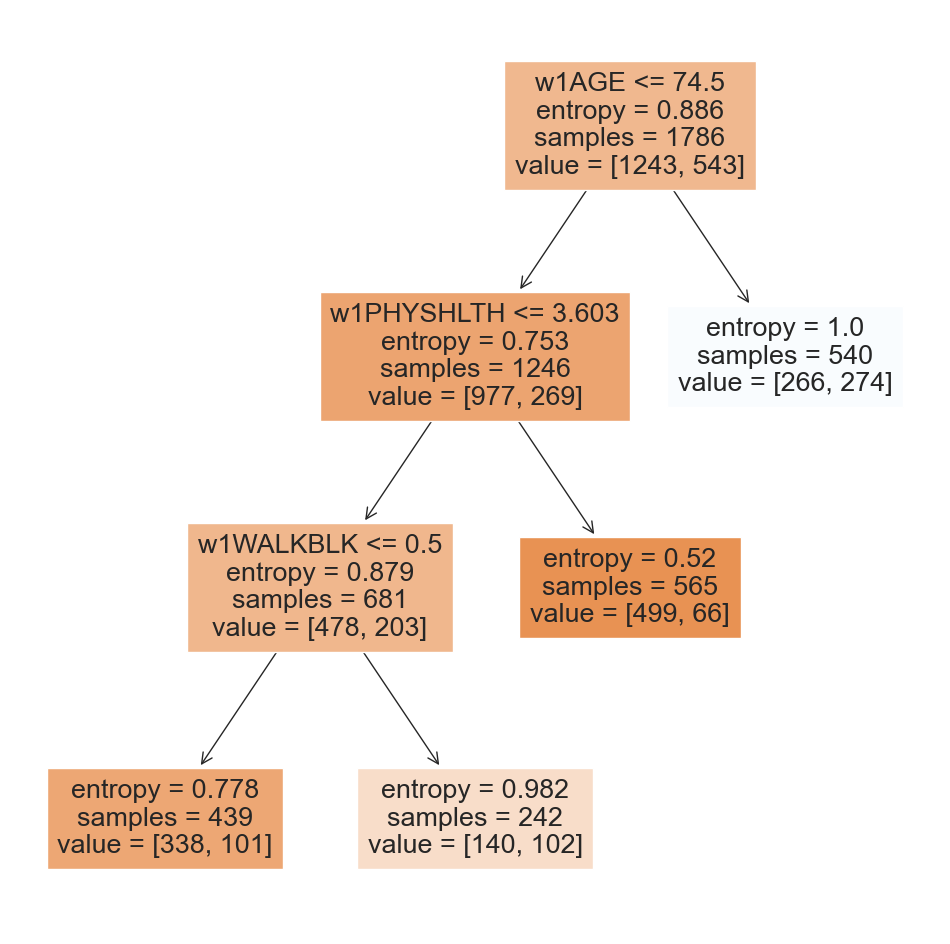

In [18]:
#We start our classification with desicion tree model. We set:
#   random seed for consideration of repetition.
#   "entropy" as criterion
#   0.01 as min_impurity_decrease, to controll the tree size and overfitting. There are lots of continous( and ordinal category) features and the size of tree can grow ... extremely large without size controlling.

#Initiate the classifier object and fit it with training set.
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.01)
DT_clf.fit(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False), y_train)

#Test it on the testing set. Print the performance and other classifying metrics to evaluate its ability.
print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

We can see form the acc-score that, the model performes poorly on the training and testing set, not higher than 70%.
This is due to under-fitting, its performance in training set is even lower than that on testing set.

The precision-recall metrics and plotted tree shows the reason: due to the class imbalance and mini-impurity-decrease limitation, the tree growing stops so early that it stops before even able to recognize the positive samples. All the samples are regarded negative.

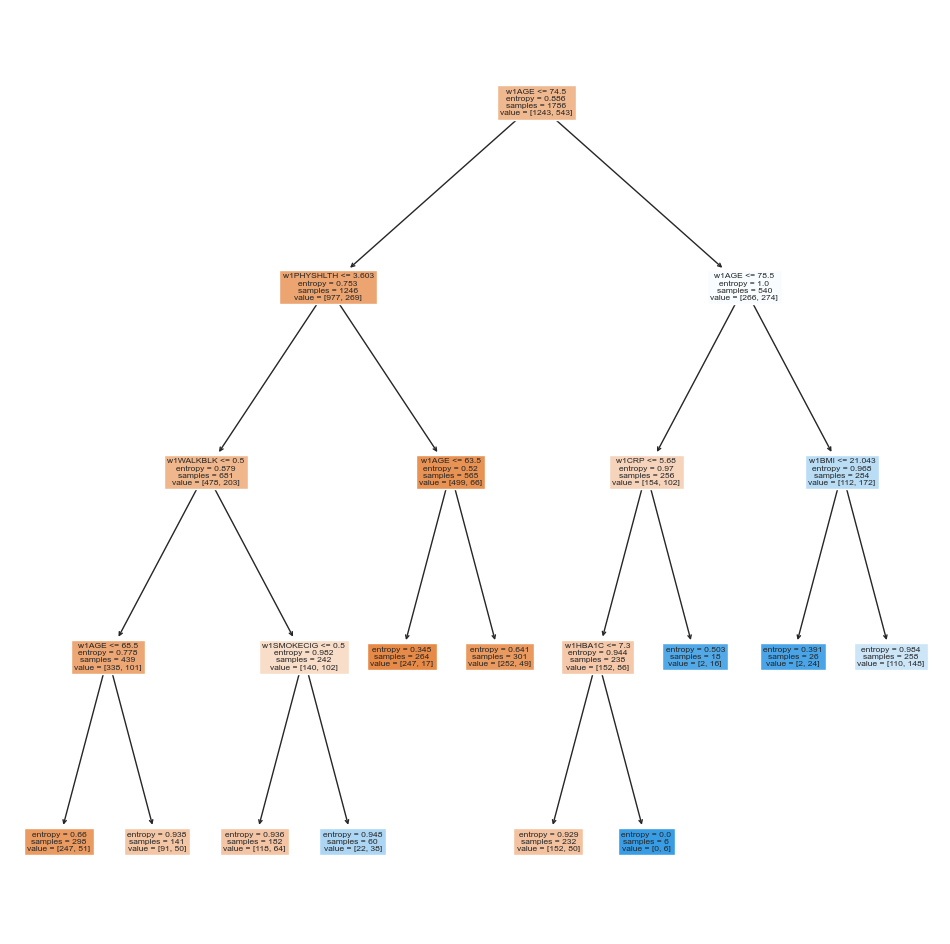

Performence on train set 0.7497200447928332
Performence on test set 0.7550335570469798
              precision    recall  f1-score   support

         0.0       0.80      0.88      0.84       426
         1.0       0.60      0.44      0.50       170

    accuracy                           0.76       596
   macro avg       0.70      0.66      0.67       596
weighted avg       0.74      0.76      0.74       596



In [19]:
#In the following training, we lower the mini-impurity-decrease limitation, to let the tree grow larger.
#Therefore, we initiate a classifier with lower limitation, and go-through the fitting, testing, and evaluating process.
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.005)
DT_clf.fit(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False), y_train)

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test))

print(metrics.classification_report(y_test, y_pred))

We can see that the tree grows much larger and negative prediction outcome starts to appear in the tree.
The overall accuracy increased after the adjustment and the F1 score of positive class increased significantly.
However, due to serious class-imbalance sample distribution, the classifier has poor performance on positive samples(Low f1 score compared to negative ones).
Therefore, in the following steps, we tried to solve the representability of our data.

As an explaination, F1 score is and combination of precise score and recall score.
Precise score evaluate how many samples predicted as certain class are truley belong to this class.
Recall score evaluate how many samples belong to certain class are recognized as this class.
And F1 score is reweighted synthesis of above two score, acting as an overall evaluation of classification ability wrt. certain class.

During exploring the data, we noticed that the gaining process of this data is by "multistage straified and clustered sampling", therefore, every sample entries is weighted based on real demographic distribution. To have a better fitting performance and better representation from sample data, we decided to adopt 'Weight' data in calculation of entropy and evaluation metrics.

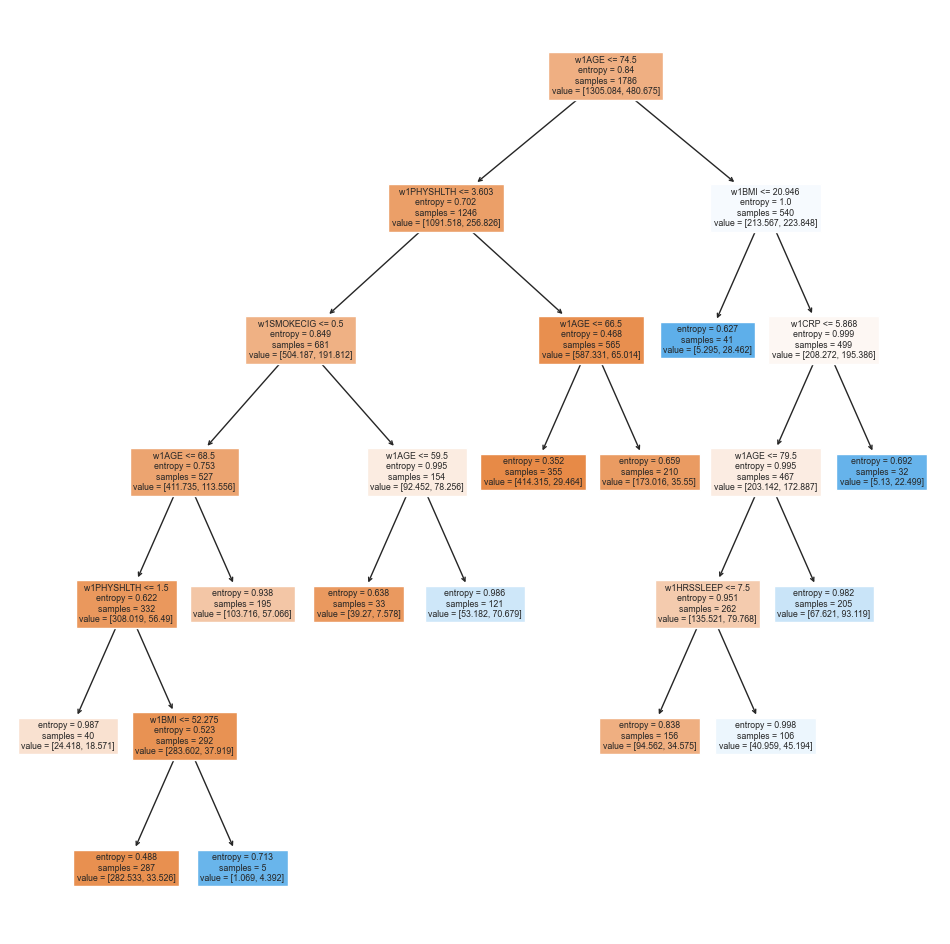

Performence on train set 0.7818376649885775
Performence on test set 0.7587489701856297
              precision    recall  f1-score   support

         0.0       0.82      0.86      0.84 452.5388123095058
         1.0       0.54      0.47      0.50 158.02167406679303

    accuracy                           0.76 610.5604863762987
   macro avg       0.68      0.66      0.67 610.5604863762987
weighted avg       0.75      0.76      0.75 610.5604863762987



In [20]:
#We pass the Weight column to classifier as sample_weight parameter, and do the fitting, predicting and evaluating process
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.005)
DT_clf.fit(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False), y_train, sample_weight=X_train['w1WEIGHT_ADJ'])

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train,
                             sample_weight=X_train['w1WEIGHT_ADJ']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['w1WEIGHT_ADJ']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['w1WEIGHT_ADJ']))

The performance increased at a significant level. Besides, the performance on each class became more balanced. After adopting the sample weight, the entropy calculated can better reflect the real sample distribution, therefore the decision tree can perform better classification on the test set.

To further explore the class-imbalance problem, we want to use the oversampling and undersampling method to create balanced dataset.
In the following sections, we will evaluate the model's performance on these two resampled dataset:

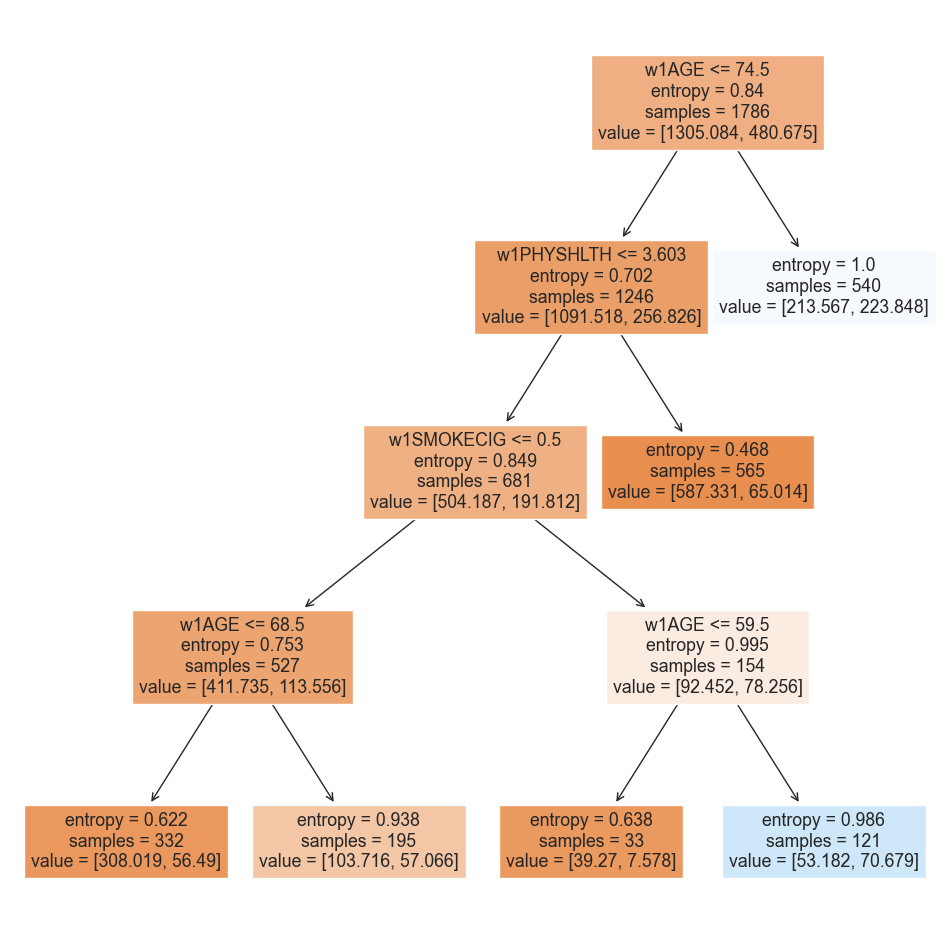

Performence on train set 0.7463842706544503
Performence on test set 0.7470590643508668
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83 452.5388123095058
         1.0       0.51      0.57      0.54 158.02167406679303

    accuracy                           0.75 610.5604863762987
   macro avg       0.68      0.69      0.68 610.5604863762987
weighted avg       0.76      0.75      0.75 610.5604863762987



In [22]:
#The re-weighted sample basing on statistics can better reflect the universal distribution, so we rised the min-impurity-decrease to 0.01. And do the same logic to train and evaluate.
DT_clf = tree.DecisionTreeClassifier(random_state=seed, criterion="entropy", max_depth=None,
                                     min_impurity_decrease=0.01)
DT_clf.fit(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False), y_train, sample_weight=X_train['w1WEIGHT_ADJ'])

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

print("Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train,
                             sample_weight=X_train['w1WEIGHT_ADJ']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['w1WEIGHT_ADJ']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['w1WEIGHT_ADJ']))

At last, we received a performance slightly better than provious one(at an ignorable level). However, this model is overall smaller, and hopefully have a better
Generalization.

## Random Forest

Later, we would like to try to ensemble individual classifier, and see if it can reach a better performance. We start with simply aggregate our best performing model and form a forest classifier.

In [23]:
#Initialize a random forest classifier with paremeters from best performing decision tree. And do the same training and evaluating process.
RF_clf = ensemble.RandomForestClassifier(random_state=seed, n_estimators=100, criterion='entropy', bootstrap=False,
                                         min_impurity_decrease=0.01)
RF_clf.fit(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False), y_train, sample_weight=X_train['w1WEIGHT_ADJ'], )

print("Performence on train set",
      metrics.accuracy_score(RF_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train,
                             sample_weight=X_train['w1WEIGHT_ADJ']))
y_pred = pd.DataFrame(RF_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['w1WEIGHT_ADJ']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['w1WEIGHT_ADJ']))

Performence on train set 0.7308289901854679
Performence on test set 0.7411858815092048
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85 452.5388123095058
         1.0       0.00      0.00      0.00 158.02167406679303

    accuracy                           0.74 610.5604863762987
   macro avg       0.37      0.50      0.43 610.5604863762987
weighted avg       0.55      0.74      0.63 610.5604863762987



/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

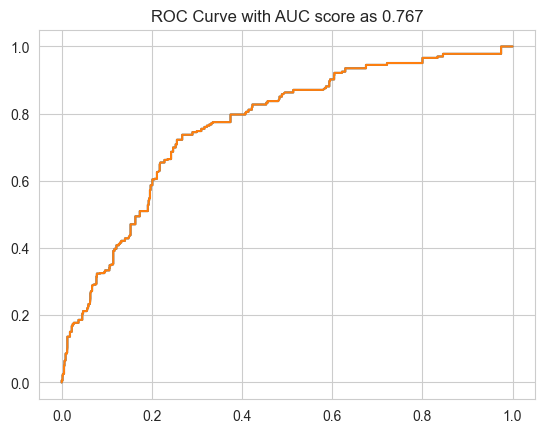

In [24]:
y_prob = pd.DataFrame(RF_clf.predict_proba(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False))[:, 1],
                      columns=["deceased"])
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob, sample_weight=X_test['w1WEIGHT_ADJ'])
plt.plot(fpr, tpr)
ra_score = metrics.roc_auc_score(y_test, y_prob, sample_weight=X_test['w1WEIGHT_ADJ'])
plt.title("ROC Curve with AUC score as {}".format(round(ra_score, 3)))
plt.plot(fpr, tpr)
plt.show()

Unfortunately, the performance of random forest decreased a lot. This is mainly because the poor performance on positive samples again.
After going back to the decision tree, we found that the decreased performance may be due to imbalance performance of decision tree.
If most of the decision trees tends to ignore the positive samples, then their aggregation will cause a worse performance, by the voting method.
Below shows the ROC curve and AUC score, which reflects the model's ability to discern positive and negative samples in a continous range. This evaluation is enabled because the prediction generated by random forest can also be interpreted as a voting rate. And this curve and score can reflect how good are individual classifiers are.

As learned from decision tree, we can improve balance by generating larger tree. In current tree, positive samples are highly underrepresented and only referred by one branch (among five).
Therefore, we increase the tree size by decreasing the min_impurity_decrease and let the tree split more.

In [25]:
# We lower the min_impurity_decrease paremeter to 3e-3 and test the preformance again.
RF_clf = ensemble.RandomForestClassifier(random_state=seed, n_estimators=45, criterion='entropy',
                                         min_impurity_decrease=3e-3, bootstrap=False)
RF_clf.fit(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False), y_train, sample_weight=X_train['w1WEIGHT_ADJ'], )

print("Performence on train set",
      metrics.accuracy_score(RF_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train,
                             sample_weight=X_train['w1WEIGHT_ADJ']))
y_pred = pd.DataFrame(RF_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['w1WEIGHT_ADJ']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['w1WEIGHT_ADJ']))

Performence on train set 0.7752229465956826
Performence on test set 0.7533465464663814
              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86 452.5388123095058
         1.0       0.73      0.08      0.14 158.02167406679303

    accuracy                           0.75 610.5604863762987
   macro avg       0.74      0.53      0.50 610.5604863762987
weighted avg       0.75      0.75      0.67 610.5604863762987



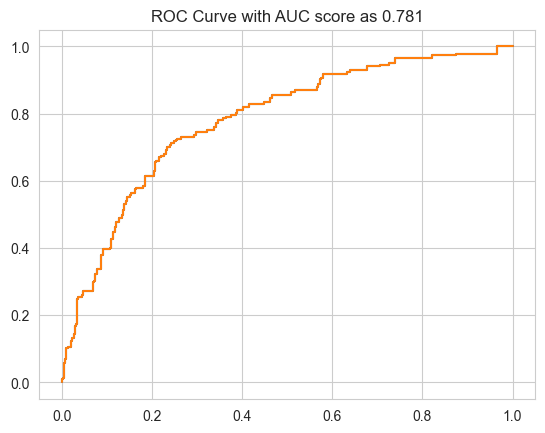

In [27]:
y_prob = pd.DataFrame(RF_clf.predict_proba(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False))[:, 1],
                      columns=["deceased"])
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob, sample_weight=X_test['w1WEIGHT_ADJ'])
plt.plot(fpr, tpr)
ra_score = metrics.roc_auc_score(y_test, y_prob, sample_weight=X_test['w1WEIGHT_ADJ'])
plt.title("ROC Curve with AUC score as {}".format(round(ra_score, 3)))
plt.plot(fpr, tpr)
plt.show()

We can see that, the overall performance and performance balance increased. Although the AUC score decreased a little, which means that individual classifiers performs slightly worse. The overall voting score increases means that there are individual trees that are highly sensitive to positive samples and will make radical prediction of positive samples.
The trees in the forest compensate each other and over-all, forms a better ensemble learner.

To get a better representation of positive samples, we want to explore more features. And hopefully, newly engaged features, although not locally the best, will make prediction of positive samples more accurate.
Therefore, we try the random feature choosing method, enabled by ensemble.ExtraTreesClassifier. ExtraTrees explore features at a higher random rate and get a better generativeness and stronger ability to go through local optimal.
We set the max-features to 0.6 to limit the feature selection scope and add randomness, in order to get a higher classification performance on minor class.

In [28]:
# We use ensemble.ExtraTreesClassifier to conduct extreme random forest and set parameters as described above. Then we run the training and testing process on it.
RF_clf = ensemble.ExtraTreesClassifier(random_state=seed, n_estimators=75, criterion='entropy', max_features=0.6,
                                       min_impurity_decrease=5e-5, bootstrap=False)
RF_clf.fit(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False), y_train, sample_weight=X_train['w1WEIGHT_ADJ'])

print("Performence on train set",
      metrics.accuracy_score(RF_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train,
                             sample_weight=X_train['w1WEIGHT_ADJ']))
y_pred = pd.DataFrame(RF_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['w1WEIGHT_ADJ']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['w1WEIGHT_ADJ']))

Performence on train set 1.0
Performence on test set 0.7628225995091953
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85 452.5388123095058
         1.0       0.56      0.38      0.45 158.02167406679303

    accuracy                           0.76 610.5604863762987
   macro avg       0.68      0.64      0.65 610.5604863762987
weighted avg       0.74      0.76      0.75 610.5604863762987



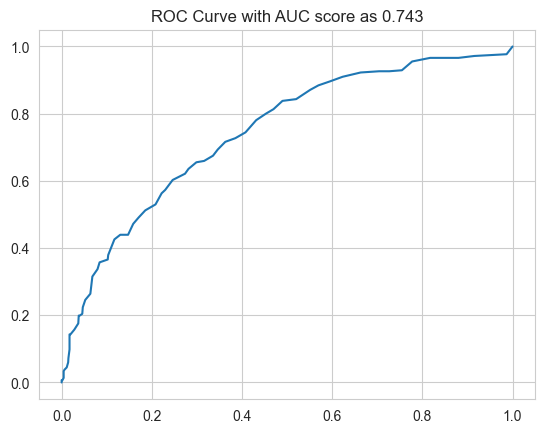

In [29]:
y_prob = pd.DataFrame(RF_clf.predict_proba(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False))[:, 1],
                      columns=["deceased"])
fpr, tpr, thr = metrics.roc_curve(y_test, y_prob, sample_weight=X_test['w1WEIGHT_ADJ'])
ra_score = metrics.roc_auc_score(y_test, y_prob, sample_weight=X_test['w1WEIGHT_ADJ'])
plt.title("ROC Curve with AUC score as {}".format(round(ra_score, 3)))
plt.plot(fpr, tpr)
plt.show()

We can observe that the performance increased significantly and the F1 score on positive samples reached to 0.49.
The extreme random exploration of features engaged more information and transcend local optimal.
And get a better performance on classifying the samples.
This models shows the complementary characteristic of ensemble learning. The AOC score decreased again, which shows that more classifiers performs less accurate, but they work better as a whole.

## Analysis and Comparison

First, we compare overall performance of the decision tree model and randomforest model

In [30]:
print("DT Performence on train set",
      metrics.accuracy_score(DT_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train,
                             sample_weight=X_train['w1WEIGHT_ADJ']))
y_pred = pd.DataFrame(DT_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("DT Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['w1WEIGHT_ADJ']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['w1WEIGHT_ADJ']))

print("RF Performence on train set",
      metrics.accuracy_score(RF_clf.predict(X_train.drop(columns='w1WEIGHT_ADJ', inplace=False)), y_train,
                             sample_weight=X_train['w1WEIGHT_ADJ']))
y_pred = pd.DataFrame(RF_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
print("RF Performence on test set", metrics.accuracy_score(y_pred, y_test, sample_weight=X_test['w1WEIGHT_ADJ']))

print(metrics.classification_report(y_test, y_pred, sample_weight=X_test['w1WEIGHT_ADJ']))

DT Performence on train set 0.7463842706544503
DT Performence on test set 0.7470590643508668
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.83 452.5388123095058
         1.0       0.51      0.57      0.54 158.02167406679303

    accuracy                           0.75 610.5604863762987
   macro avg       0.68      0.69      0.68 610.5604863762987
weighted avg       0.76      0.75      0.75 610.5604863762987

RF Performence on train set 1.0
RF Performence on test set 0.7628225995091953
              precision    recall  f1-score   support

         0.0       0.81      0.90      0.85 452.5388123095058
         1.0       0.56      0.38      0.45 158.02167406679303

    accuracy                           0.76 610.5604863762987
   macro avg       0.68      0.64      0.65 610.5604863762987
weighted avg       0.74      0.76      0.75 610.5604863762987



According to our training process,
Random forest classifier have better over-all test accuracy and performance balance on classes. However, RF model also have higher over-fitting rate, this is due to we cannot balance the tree size and num of estimator and get to a globally optimal parameter set.

Random forest engages more tree classifiers and adapted more features, therefore has better perspective on positive samples, which is the advantages of ensemble learning.
As we've explored before, our dataset have limited number of samples compared to features and co-influcing features with non-linear efficient. When general up-sampling and down-sampling don't work, ensembel method can produce an alternative solution.

Second, we compare the features used by two models.

                 ftr
w1AGE       0.665269
w1PHYSHLTH  0.222210
w1SMOKECIG  0.112521


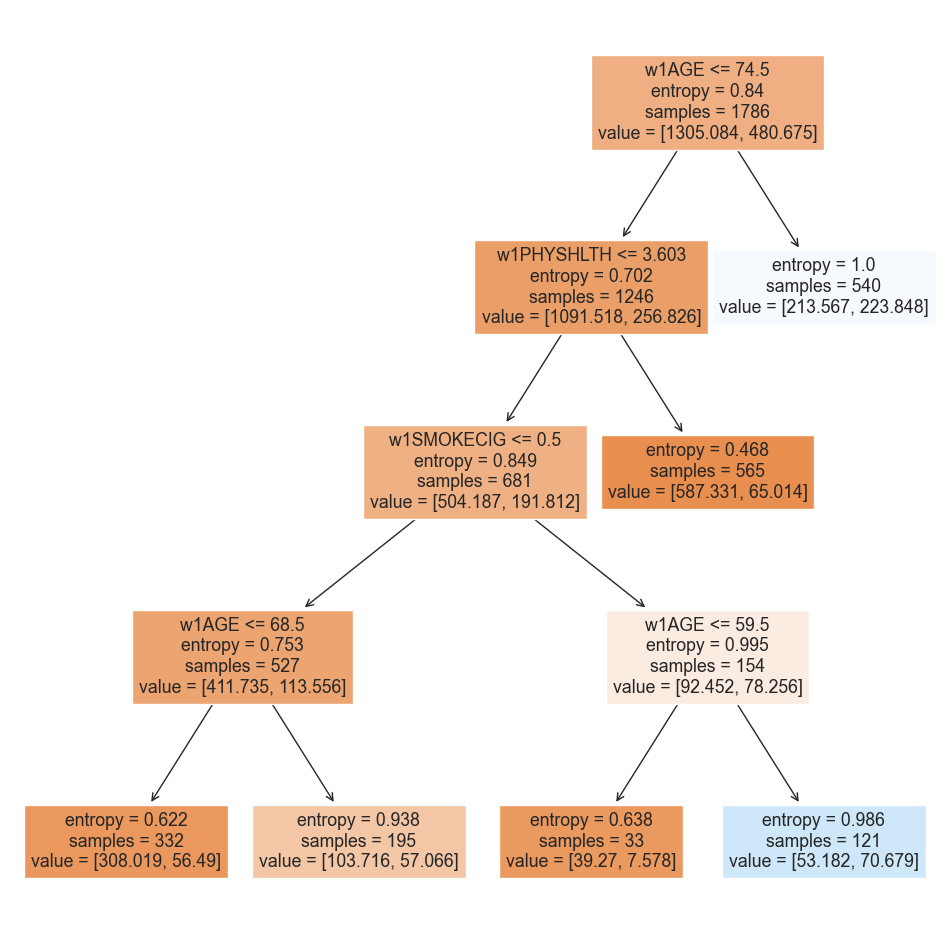

In [31]:
#According to sklearn, Feature importance are provided by the fitted attribute feature_importances_ and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree, which reflects how significant these features are related to classification.
ftr_sig = pd.DataFrame(DT_clf.feature_importances_, index=ftr_names, columns=['ftr'])
print(ftr_sig[ftr_sig['ftr'] != 0].sort_values(by='ftr', ascending=False))

plt.figure(figsize=(12, 12))
tree.plot_tree(DT_clf, filled=True, feature_names=ftr_names)
plt.show()

We can see that in decision tree generation, the model select the most important features on the order of their significance and split the samples.
While in following analysis, we can see that exRF model have a wider scope of feature selection and application.

In [32]:
#First, we calculate the overall feature significance in random forest and sort them in descending order.
ftr_sig = pd.DataFrame(RF_clf.feature_importances_, index=ftr_names, columns=['ftr'])
ftr_sig.sort_values(by='ftr', ascending=False, inplace=True)
print(ftr_sig)

#Second, we calculate the appearance of features in individual trees' top level;
#By this process, we can see how popular is each trees and how they are used in constructing the individual trees
idxs = []
scores = []
ftrs = []
for idx, dt in enumerate(RF_clf.estimators_):
    scores.append(
        dt.score(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False), y_test, sample_weight=X_test['w1WEIGHT_ADJ']))
    idxs.append(idx)
    ftr_idx = (-dt.feature_importances_).argsort()[:5].astype(int)
    ftr_list = []
    for i in ftr_idx:
        ftr_list.append(ftr_names[i])
    ftrs.append(ftr_list)
ftr_df = pd.DataFrame({
    'idx': idxs,
    'scores': scores,
    'top_ftrs': ftrs
})
ftr_df = ftr_df.sort_values(by='scores', ascending=False, inplace=False)
ftr_df

                        ftr
w1AGE              0.143731
w1PHYSHLTH         0.052456
w1BMI              0.051650
w1dhea_mean        0.046897
w1HRSSLEEP         0.046497
w1CRP              0.045673
w1WALKBLK          0.044610
w1SYSTOLIC_MEAN    0.043870
w1HSASSETS_RECODE  0.041757
w1MNTLHLTH         0.040309
num_unique         0.039574
avg_close          0.039508
w1HBA1C            0.039131
avg_talk           0.037405
w1EDUC             0.036918
w1PHYSACT          0.035386
prop_live          0.033468
w1SMOKECIG         0.032495
net_count          0.031690
w1GENDER           0.028937
w1ALCOHOL          0.027409
w1married          0.023427
w1CONDITNS_3       0.018864
w1raceblk          0.018338


/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreeClassifier was fitted without feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreeClassifier was fitted without feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreeClassifier was fitted without feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreeClassifier was fitted without feature names
  warnings.warn(
/Users/lyu/Opt/anaconda3/envs/m1_torch/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ExtraTreeClassifier was fitted without feature names
  warnings.warn(
/Users/lyu/Opt/anaco

,idx,scores,top_ftrs
41,41,0.717816,"[w1AGE, w1CRP, w1PHYSHLTH, num_unique, w1BMI]"
29,29,0.714249,"[w1AGE, w1BMI, w1PHYSHLTH, w1HRSSLEEP, avg_close]"
31,31,0.702971,"[w1AGE, w1PHYSHLTH, w1HRSSLEEP, w1dhea_mean, w..."
64,64,0.701408,"[w1AGE, w1dhea_mean, w1HRSSLEEP, w1BMI, w1WALK..."
20,20,0.698714,"[w1AGE, w1PHYSHLTH, w1HBA1C, w1dhea_mean, w1BMI]"
...,...,...,...
26,26,0.648027,"[w1AGE, w1HRSSLEEP, w1HSASSETS_RECODE, w1MNTLH..."
37,37,0.647517,"[w1AGE, w1MNTLHLTH, w1PHYSHLTH, num_unique, w1..."
5,5,0.641964,"[w1AGE, w1dhea_mean, w1PHYSHLTH, w1BMI, w1CRP]"
71,71,0.640184,"[w1AGE, w1PHYSHLTH, w1CRP, w1HBA1C, w1HSASSETS..."


In [42]:
##筛选前n个feature的tree
ftr_l = ['w1AGE', 'w1PHYSHLTH']
for idx, row in ftr_df.iterrows():
    flag = 1
    for j in range(len(ftr_l)):
        #print(ftr_l[j], row['top_ftrs'][j])
        if ftr_l[j] != row['top_ftrs'][j]:
            flag = 0
    if flag:
        print(list(row))

[31, 0.7029710897853414, ['w1AGE', 'w1PHYSHLTH', 'w1HRSSLEEP', 'w1dhea_mean', 'w1HSASSETS_RECODE']]
[20, 0.6987139955031902, ['w1AGE', 'w1PHYSHLTH', 'w1HBA1C', 'w1dhea_mean', 'w1BMI']]
[21, 0.6965505760826222, ['w1AGE', 'w1PHYSHLTH', 'w1dhea_mean', 'w1HRSSLEEP', 'w1SYSTOLIC_MEAN']]
[38, 0.6943401187592666, ['w1AGE', 'w1PHYSHLTH', 'avg_talk', 'w1BMI', 'w1CRP']]
[9, 0.6915560705695359, ['w1AGE', 'w1PHYSHLTH', 'w1dhea_mean', 'w1HSASSETS_RECODE', 'w1MNTLHLTH']]
[44, 0.6911550129300377, ['w1AGE', 'w1PHYSHLTH', 'w1dhea_mean', 'w1BMI', 'w1CRP']]
[59, 0.6823918466515988, ['w1AGE', 'w1PHYSHLTH', 'w1BMI', 'w1dhea_mean', 'avg_talk']]
[15, 0.6813531012873072, ['w1AGE', 'w1PHYSHLTH', 'w1dhea_mean', 'w1SYSTOLIC_MEAN', 'w1BMI']]
[12, 0.6770651765428432, ['w1AGE', 'w1PHYSHLTH', 'avg_close', 'w1SYSTOLIC_MEAN', 'w1dhea_mean']]
[63, 0.6743269214183317, ['w1AGE', 'w1PHYSHLTH', 'w1dhea_mean', 'w1BMI', 'w1CRP']]
[57, 0.6711469852306607, ['w1AGE', 'w1PHYSHLTH', 'w1HRSSLEEP', 'w1BMI', 'w1SYSTOLIC_MEAN']]
[36,

We can see that, most of the decision trees in RF model select the features by significance, nearly all trees starts at Age. However, they split and explore different features at following stages, and explore different features to capture patterns of positive samples.

In [33]:
# We count the appearance of features in top-5 stages and see their popularity.
# And we can see that the feature selection aligns with their entropy gain.
ftr_list = []
for idx, row in ftr_df.iterrows():
    ftr_list += row['top_ftrs']
collections.Counter(ftr_list)

Counter({'w1AGE': 75,
         'w1CRP': 24,
         'w1PHYSHLTH': 46,
         'num_unique': 10,
         'w1BMI': 42,
         'w1HRSSLEEP': 32,
         'avg_close': 7,
         'w1dhea_mean': 33,
         'w1HSASSETS_RECODE': 19,
         'w1WALKBLK': 26,
         'w1HBA1C': 9,
         'w1MNTLHLTH': 10,
         'w1SYSTOLIC_MEAN': 23,
         'avg_talk': 6,
         'net_count': 1,
         'w1GENDER': 1,
         'w1EDUC': 5,
         'prop_live': 3,
         'w1PHYSACT': 3})

Third, we analyze the false case of these two models:

In [34]:
#Select the false case basing on mismatch between y_pred and labels
y_pred_dt = pd.DataFrame(DT_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
y_prob_dt = pd.DataFrame(DT_clf.predict_proba(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False))[:, 1],
                         columns=["deceased"])
X_wrong_dt = X_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['deceased'] != y_test.reset_index(inplace=False)['deceased']
    ].drop(columns='w1WEIGHT_ADJ', inplace=False)
y_wrong_dt = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_dt['deceased'] != y_test.reset_index(inplace=False)['deceased']
    ]
dt_wrong = pd.concat([y_wrong_dt, X_wrong_dt], axis=1)
dt_wrong

,deceased,w1SMOKECIG,w1ALCOHOL,w1GENDER,w1CONDITNS_3,w1married,w1raceblk,w1PHYSACT,w1EDUC,w1HSASSETS_RECODE,...,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean,net_count,num_unique,prop_live,avg_talk,avg_close
0,0.0,1.0,1.0,1.0,0.0,1,1,2.0,4.0,4.000000,...,17.609476,6.097641,3.19458,4.0,33.049999,5,2,0.000000,0.400000,3.800000
1,1.0,0.0,0.0,2.0,1.0,1,0,3.0,1.0,3.000000,...,25.143921,5.100000,9.64000,5.0,8.935000,4,4,0.250000,0.250000,3.000000
2,1.0,0.0,0.0,2.0,0.0,0,0,4.0,2.0,4.000000,...,38.068226,5.800000,0.64700,6.0,48.595001,5,3,0.000000,1.000000,3.000000
5,0.0,0.0,0.0,1.0,0.0,1,0,4.0,4.0,4.000000,...,36.188950,6.000000,1.21800,8.0,10.530000,5,5,0.200000,0.400000,3.200000
17,0.0,0.0,1.0,2.0,0.0,1,0,4.0,4.0,3.649512,...,23.911564,6.097641,3.19458,9.0,64.914999,5,2,0.000000,0.000000,2.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,0.0,0.0,0.0,2.0,0.0,0,1,4.0,1.0,3.649512,...,34.332088,6.600000,1.66500,8.0,66.364998,3,2,0.333333,0.333333,3.666667
585,0.0,0.0,0.0,2.0,0.0,0,0,0.0,1.0,3.649512,...,32.413456,6.500000,1.25200,5.0,52.921454,2,2,0.000000,0.000000,3.000000
589,0.0,0.0,0.0,1.0,0.0,0,0,4.0,1.0,3.649512,...,33.356873,9.000000,2.32300,8.0,24.885000,3,3,0.000000,0.000000,3.000000
591,0.0,0.0,1.0,2.0,0.0,0,0,4.0,3.0,4.000000,...,24.560688,5.800000,0.72000,7.0,99.505001,5,3,0.000000,0.000000,2.000000


When examining the wrong predicted cases, we find multiple reasons 1) young, wealthy, but has high C-Reactive Protein (indicating high inflammation of diseases within the body) and high BMI (indicating high levels of obesity). Hence, they died from diseases of wealth. Eg.., Index 393, 586, 86. Because most RF trees consider age as the predictive feature at the first level, the predictions would be wrong.
This is caused by, DT model failed to capture patterns of positive sample, due to class-imbalance data.

In [35]:
#DO the same process to RF model
y_pred_rf = pd.DataFrame(RF_clf.predict(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False)), columns=["deceased"])
y_prob_rf = pd.DataFrame(RF_clf.predict_proba(X_test.drop(columns='w1WEIGHT_ADJ', inplace=False))[:, 1],
                         columns=["deceased"])
X_wrong_rf = X_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_rf['deceased'] != y_test.reset_index(inplace=False)['deceased']
    ].drop(columns='w1WEIGHT_ADJ', inplace=False)

y_wrong_rf = y_test.reset_index(inplace=False).drop(columns='index', inplace=False).loc[
    y_pred_rf['deceased'] != y_test.reset_index(inplace=False)['deceased']
    ]
rf_wrong = pd.concat([y_wrong_rf, X_wrong_rf], axis=1)
rf_wrong

,deceased,w1SMOKECIG,w1ALCOHOL,w1GENDER,w1CONDITNS_3,w1married,w1raceblk,w1PHYSACT,w1EDUC,w1HSASSETS_RECODE,...,w1BMI,w1HBA1C,w1CRP,w1HRSSLEEP,w1dhea_mean,net_count,num_unique,prop_live,avg_talk,avg_close
0,0.0,1.0,1.0,1.0,0.0,1,1,2.0,4.0,4.000000,...,17.609476,6.097641,3.19458,4.0,33.049999,5,2,0.000000,0.400000,3.800000
2,1.0,0.0,0.0,2.0,0.0,0,0,4.0,2.0,4.000000,...,38.068226,5.800000,0.64700,6.0,48.595001,5,3,0.000000,1.000000,3.000000
5,0.0,0.0,0.0,1.0,0.0,1,0,4.0,4.0,4.000000,...,36.188950,6.000000,1.21800,8.0,10.530000,5,5,0.200000,0.400000,3.200000
19,1.0,0.0,0.0,2.0,1.0,0,1,4.0,3.0,1.000000,...,25.744629,6.500000,1.76900,5.0,225.720001,2,2,0.000000,0.500000,4.000000
23,1.0,0.0,0.0,1.0,0.0,0,1,3.0,2.0,3.649512,...,29.095167,6.097641,3.19458,7.0,25.250000,3,3,0.666667,1.000000,3.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,1.0,0.0,1.0,1.0,0.0,1,0,0.0,3.0,3.649512,...,27.169083,6.097641,4.76500,6.0,52.921454,2,2,0.500000,0.500000,3.500000
582,1.0,0.0,0.0,2.0,0.0,0,0,3.0,2.0,3.649512,...,23.591831,6.097641,3.19458,7.0,75.594997,3,3,0.000000,0.333333,2.666667
585,0.0,0.0,0.0,2.0,0.0,0,0,0.0,1.0,3.649512,...,32.413456,6.500000,1.25200,5.0,52.921454,2,2,0.000000,0.000000,3.000000
593,1.0,0.0,1.0,2.0,0.0,1,0,4.0,3.0,4.000000,...,30.465105,6.097641,3.19458,7.0,52.921454,4,3,0.500000,0.500000,2.000000


BMI is among the most predictive features. However, these respondents who wrongly predicted their disposition status all have their BMI in a relatively normal range. This corroborates the previous findings that the BMI alone may be at odds with other health factors in predicting mortality (McClintock et al., 2016) most of the respondents also have excellent self-rated health, however, their systolic blood pressure is also high. We suspect it might be because we attempted to avoid overfitting and may have omitted this milder pattern. It might also be because the depth of the tree limited the algorithm from putting the mortality factor of hypertension alongside many others that are even more important.

## Conclusion
- We can see that in decision tree generation, the model selects the most important features on the order of their significance and splits the samples.
- RF has better overall test accuracy and performance balance in classes.
- RF engages more tree classifiers and adapted more features, therefore has a better perspective on positive samples, which is the advantage of ensemble learning, especially given our dataset has a limited number of samples compared to features and co-influencing features with non-linear eﬀiciency.

In [36]:
###s